In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
from caffe import layers as L

# matplotlib config
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [6]:
caffe.set_device(0)
caffe.set_mode_gpu()

from train_places_net import MEAN, minivggnet, to_tempfile, get_split

def load_net(i, labels):
    with open(get_split('val'), 'r') as fh:
        images = fh.read().split("\n")
    print("True category is: {}".format(labels[int(images[i].split(" ")[1])]))
    source = to_tempfile(images[i])

    transform_param = dict(mirror=False, crop_size=96, mean_value=MEAN)
    places_data, places_labels = L.ImageData(
        transform_param=transform_param,
        source=source, root_folder='./images/', 
        shuffle=False, batch_size=1, ntop=2)
    net_path = minivggnet(
        data=places_data, labels=places_labels,
        train=False, cudnn=False, with_labels=False)
    
    net = caffe.Net(net_path, 'snapshot/place_net_iter_35000.caffemodel', caffe.TEST)

    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array(MEAN)) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    return net, transformer

In [7]:
from ipywidgets import interact

True category is: /a/aquarium
Predicted class is /a/aquarium

/a/aquarium (p=0.911017894745)
/r/rainforest (p=0.0201164614409)
/i/iceberg (p=0.0160505138338)
/v/volcano (p=0.0135069442913)
/b/botanical_garden (p=0.00538687733933)


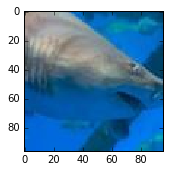

In [8]:
@interact
def predict(i=(0, 1000)):
    # load labels
    labels_filename = 'development_kit/data/categories.txt'
    labels = np.loadtxt(labels_filename, str, delimiter=' ')[:, 0]

    # load network
    net, transformer = load_net(i, labels)

    # compute predictions
    out = net.forward()
    probs = out['probs'][0]
    print("Predicted class is {}\n".format(labels[probs.argmax()]))
    
    # sort top k predictions from softmax output
    top_k = probs.argsort()[::-1][:5]
    categories = labels[top_k]
    for cat, p in zip(categories, probs[top_k]):
        print("{} (p={})".format(cat, p))
    
    image = transformer.deprocess('data', net.blobs['data'].data[0])
    plt.imshow(image)
    fig = plt.gcf()
    fig.set_size_inches(2.5, 2.5)

    return net

True category is: /c/cockpit
Predicted class is /c/cockpit

/c/cockpit (p=0.353126108646)
/b/bus_interior (p=0.123423665762)
/p/parking_lot (p=0.103397503495)
/b/boat_deck (p=0.0684739500284)
/a/assembly_line (p=0.035284165293)


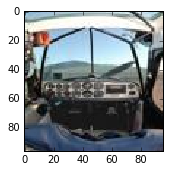

In [9]:
net = predict(25)

Helper functions for visualization

In [10]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [11]:
for layer, blob in net.blobs.iteritems():
    print("{} {}".format(layer, tuple(blob.shape)))

data (1, 3, 96, 96)
ignored_label (1,)
conv1 (1, 96, 45, 45)
norm1 (1, 96, 45, 45)
pool1 (1, 96, 15, 15)
conv2 (1, 256, 11, 11)
pool2 (1, 256, 6, 6)
conv3 (1, 512, 6, 6)
conv4 (1, 512, 6, 6)
conv5 (1, 512, 5, 5)
pool5 (1, 512, 2, 2)
conv6 (1, 384, 2, 2)
conv7 (1, 384, 2, 2)
conv8 (1, 256, 2, 2)
pool8 (1, 256, 1, 1)
fc9 (1, 2048)
fc10 (1, 1024)
fc11 (1, 100)
probs (1, 100)


## Layer 1

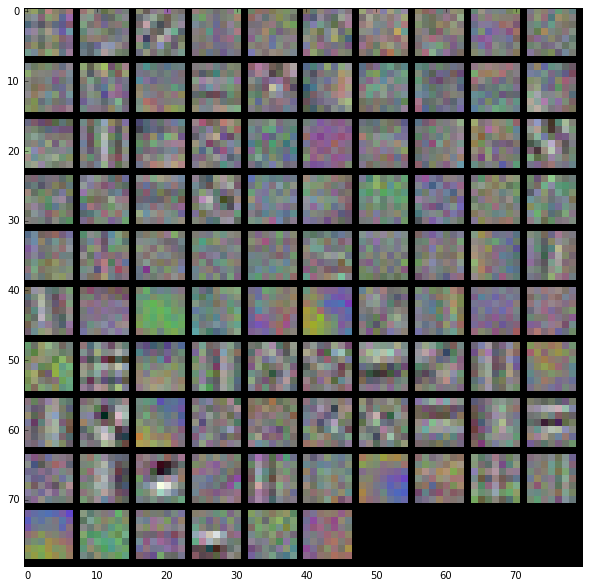

In [12]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

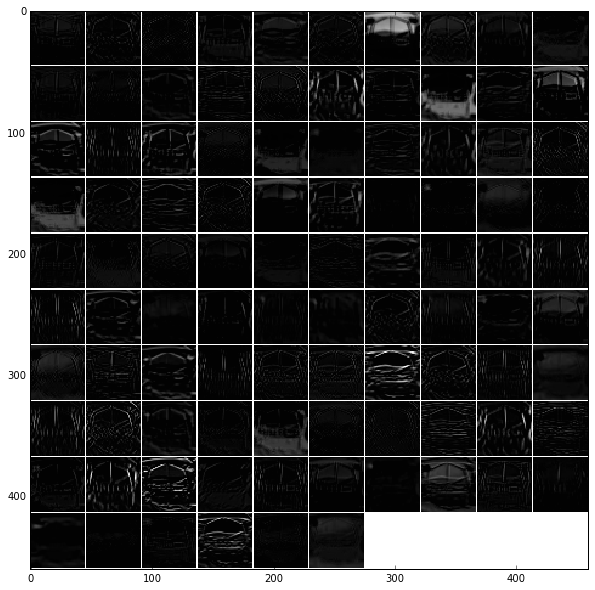

In [13]:
feat = net.blobs['conv1'].data[0]
vis_square(feat, padval=1)

## Layer 2

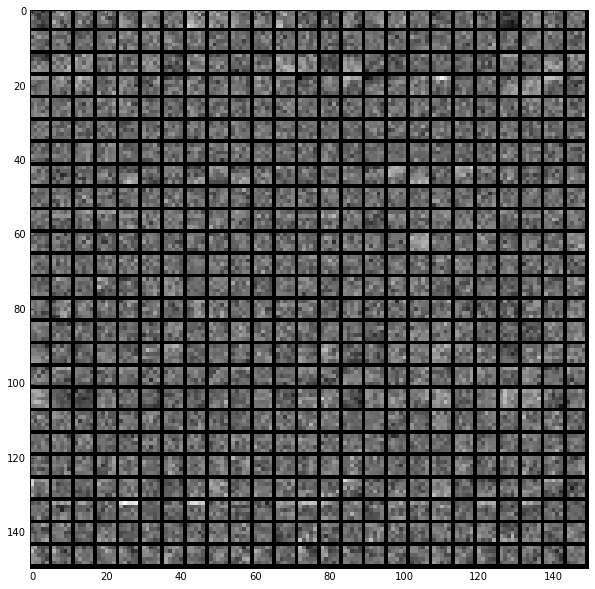

In [14]:
filters = net.params['conv2'][0].data
vis_square(filters[:25, :25].reshape(25**2, 5, 5))

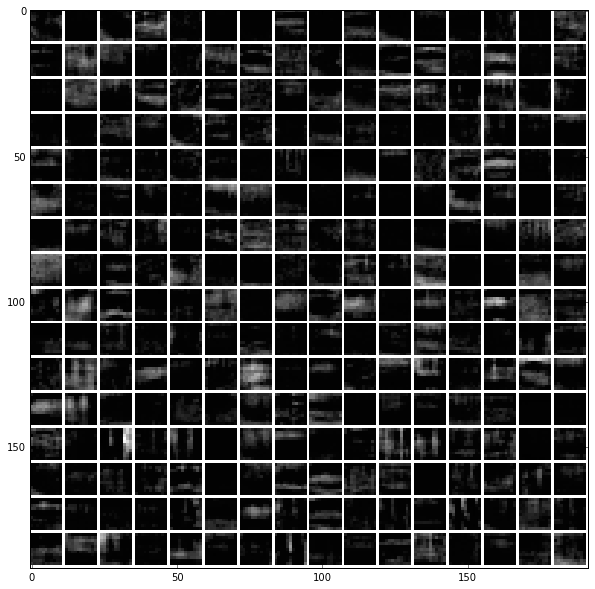

In [15]:
feat = net.blobs['conv2'].data[0]
vis_square(feat, padval=1)

## Layer 3

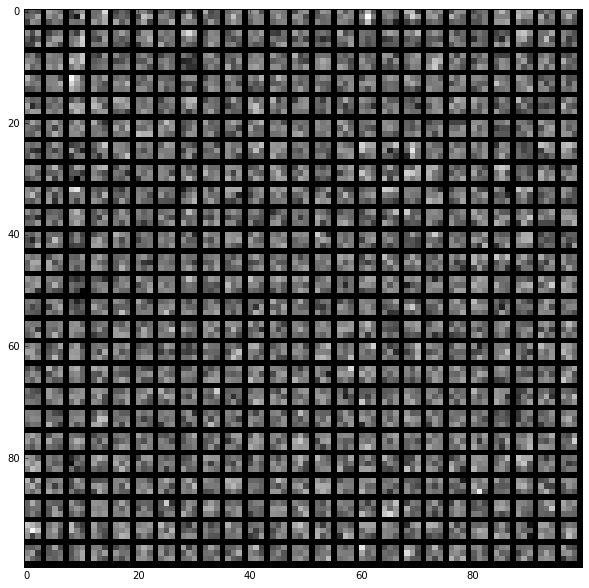

In [16]:
filters = net.params['conv3'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

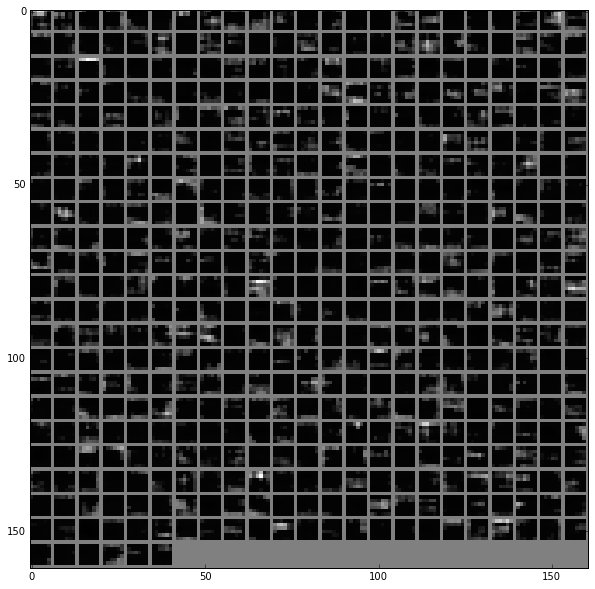

In [17]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

## Layer 4

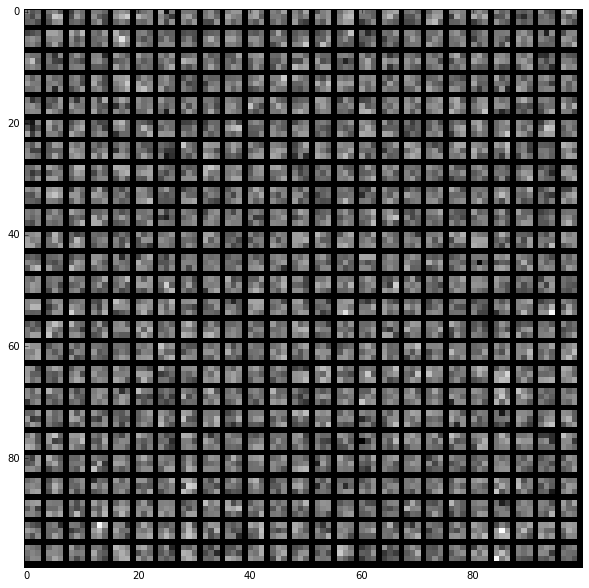

In [18]:
filters = net.params['conv4'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

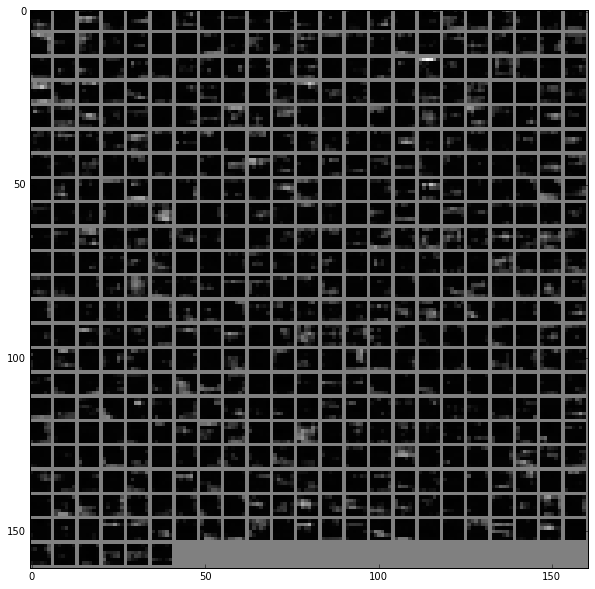

In [19]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

## Layer 5

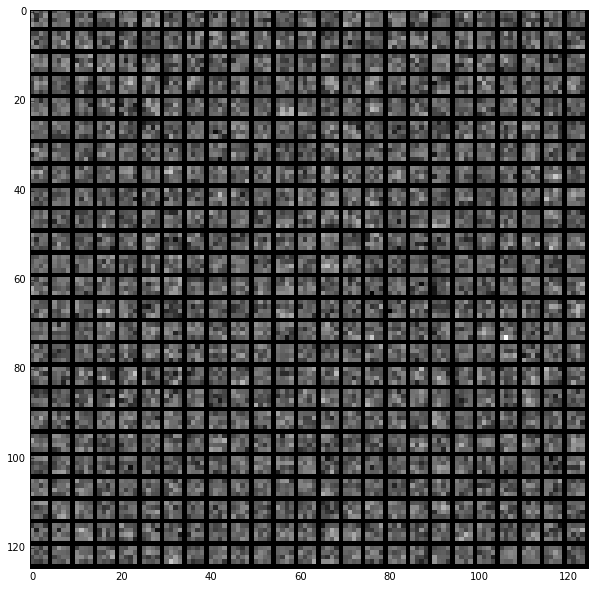

In [20]:
filters = net.params['conv5'][0].data
vis_square(filters[:25, :25].reshape(25**2, 4, 4))

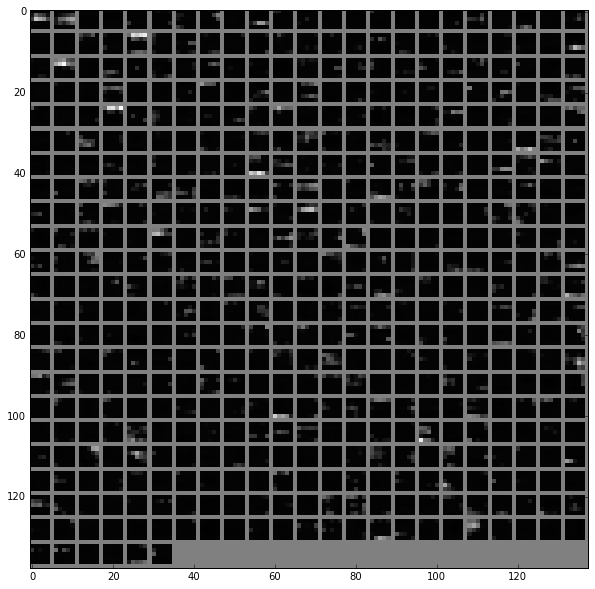

In [21]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

## Layer 6

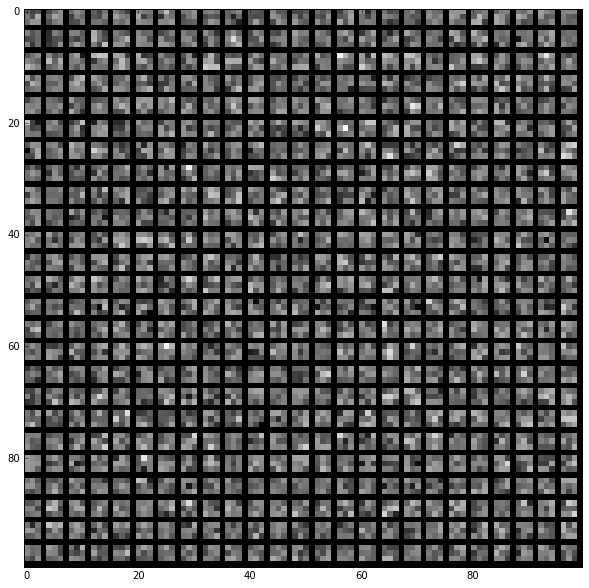

In [22]:
filters = net.params['conv6'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

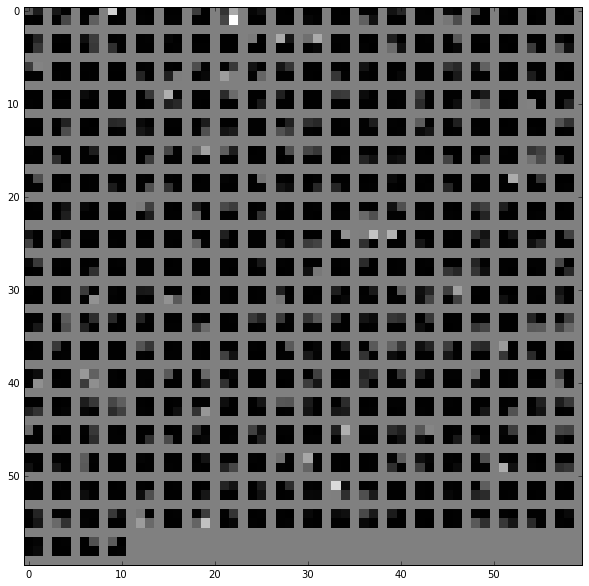

In [23]:
feat = net.blobs['conv6'].data[0]
vis_square(feat, padval=0.5)

## Layer 7

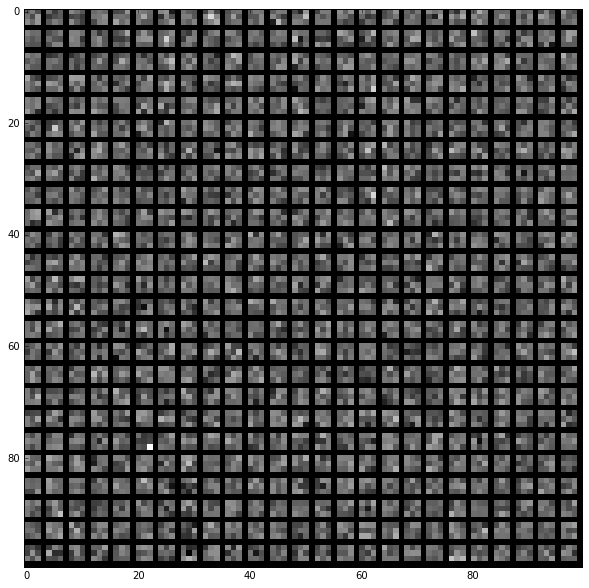

In [24]:
filters = net.params['conv7'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

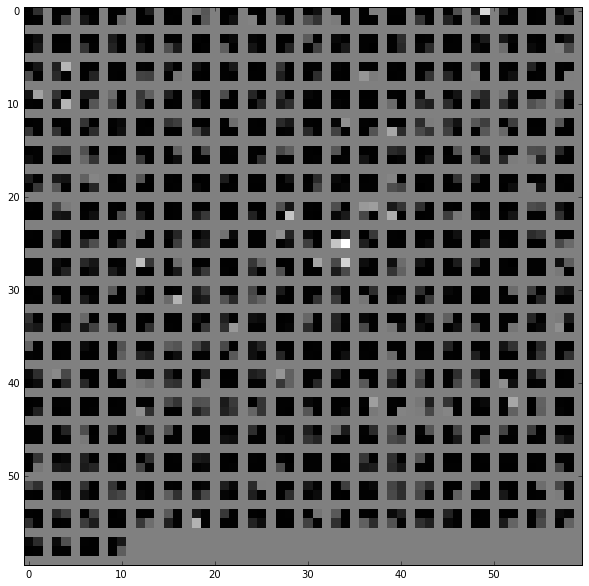

In [25]:
feat = net.blobs['conv7'].data[0]
vis_square(feat, padval=0.5)

## Layer 8

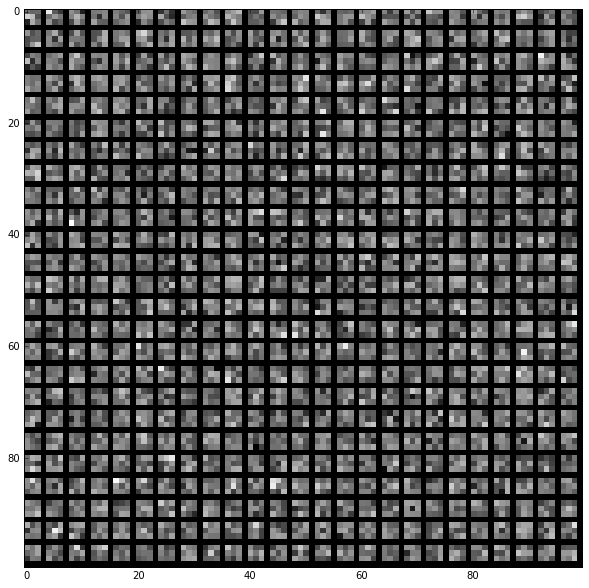

In [26]:
filters = net.params['conv8'][0].data
vis_square(filters[:25, :25].reshape(25**2, 3, 3))

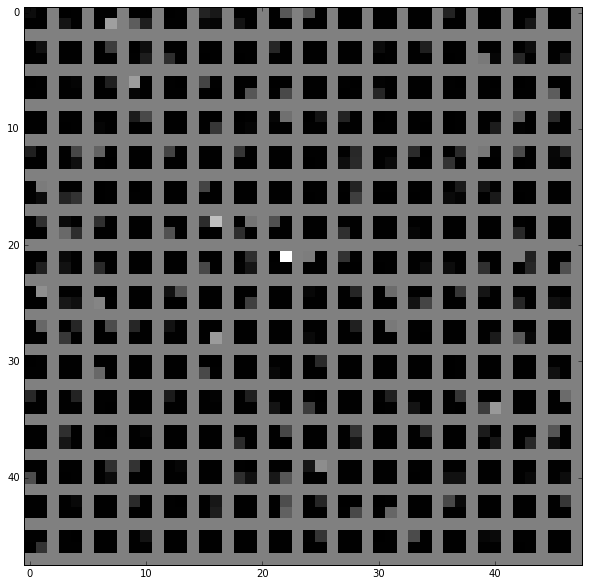

In [27]:
feat = net.blobs['conv8'].data[0]
vis_square(feat, padval=0.5)

The eighth layer after pooling, `pool8`

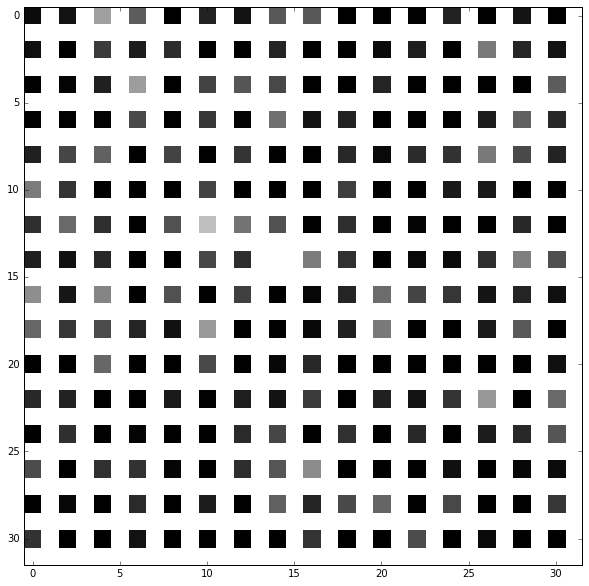

In [28]:
feat = net.blobs['pool8'].data[0]
vis_square(feat, padval=1)

## Layer 9

The first fully connected layer, `fc9`

We show the output values and the histogram of the positive values

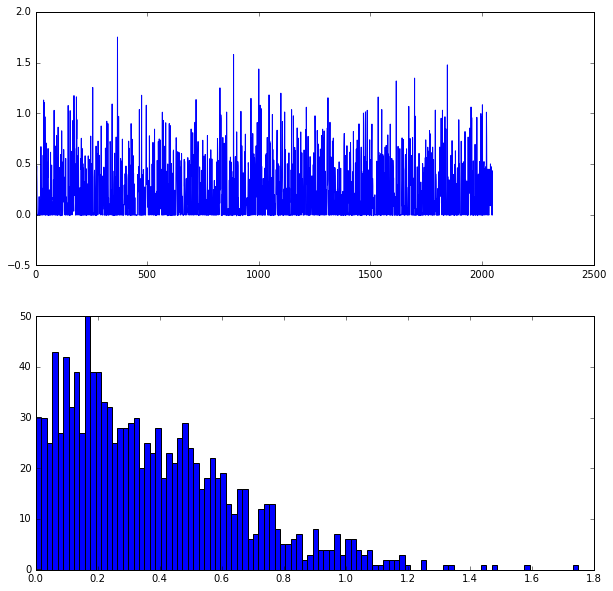

In [29]:
feat = net.blobs['fc9'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

## Layer 10

The second fully connected layer, `fc10` (rectified)

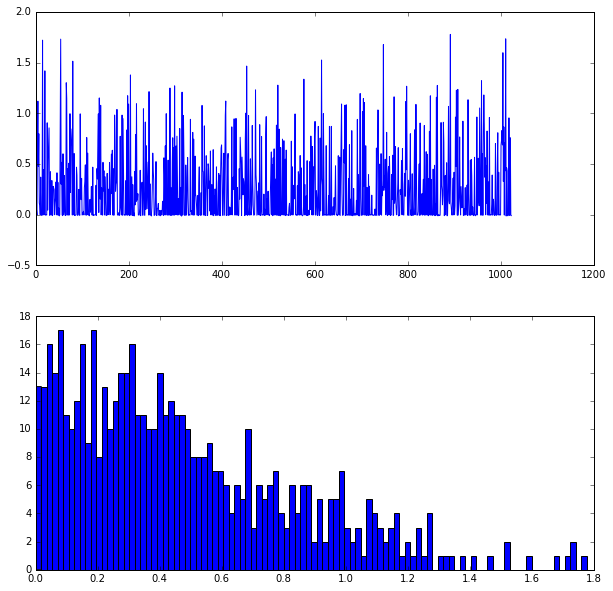

In [30]:
feat = net.blobs['fc10'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

## Output layer

The final probability output, `prob`

(-0.5, 100.5)

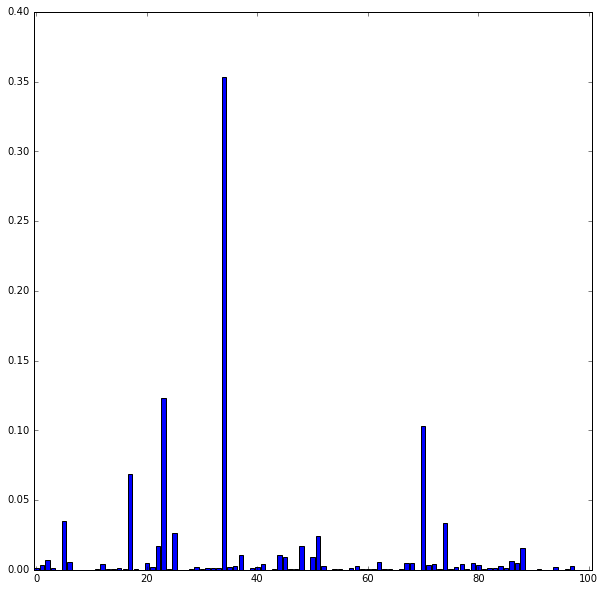

In [31]:
feat = net.blobs['probs'].data[0].flat
fig, ax = plt.subplots()
ax.bar(np.arange(len(feat)), feat, align='center')
ax.set_xlim(-0.5, 100.5)